Кулаков Ярослав Михайлович BCI.

In [481]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cross_decomposition import PLSRegression
from IPython.display import clear_output
import imageio
import os
import matplotlib
import time 
from sklearn.linear_model import LinearRegression

Загрузка датасета.

In [11]:
X_train = scipy.io.loadmat('ECoG_data/ECoG_X_train.mat')
X_train = X_train['X_train']
X_train.shape

(12801, 32, 27)

In [30]:
X_test = scipy.io.loadmat('ECoG_data/ECoG_X_test.mat')
X_test = X_test['X_hold_out']
X_test.shape

(6087, 32, 27)

In [14]:
y_train = scipy.io.loadmat('ECoG_data/ECoG_Y_train.mat')
y_train = y_train['Y_train']
y_train.shape

(12801, 3)

In [33]:
y_test = scipy.io.loadmat('ECoG_data/ECoG_Y_test.mat')
y_test = y_test['Y_hold_out']
y_test.shape

(6087, 3)

Посмотрим на сигнал по первому каналу.

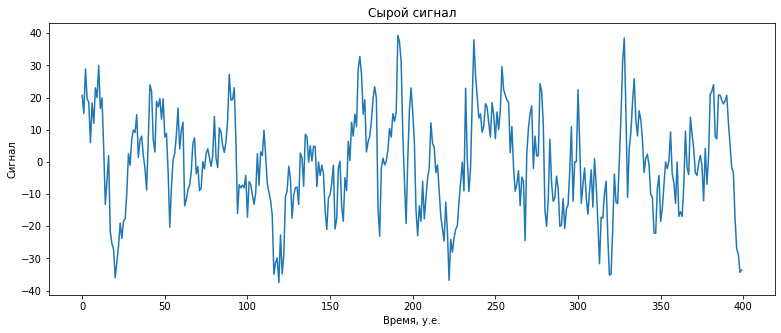

In [485]:
plt.figure(figsize=(13,5))
plt.title("Сырой сигнал")
plt.plot(np.arange(400), X_test[:400, 0,0])
plt.xlabel("Время, у.е.")
plt.ylabel("Сигнал")
plt.show()

Посмотрим на преобразованные в частотно-временное пространство по первому каналу.

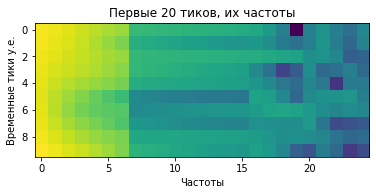

In [488]:
plt.imshow(X_test[:10, 0, 1:26])
plt.title("Первые 20 тиков, их частоты")
plt.xlabel("Частоты")
plt.ylabel("Временные тики у.е.")
plt.show()

Посмотрим на часть траектории кисти в 3D.

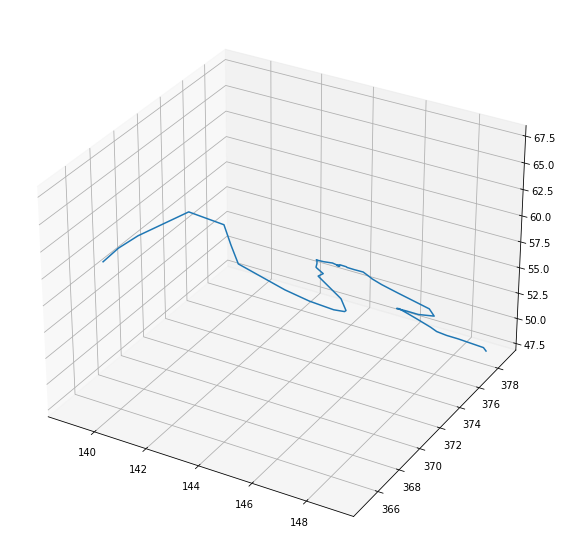

In [455]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.plot3D(y_train[:50,0], y_train[:50,1], y_train[:50,2])
plt.show()

Обучим PLS. Сгенерируем признаки : экспоненциируем все данные.

In [346]:
pls2 = PLSRegression(n_components=30, max_iter=20000).fit(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))),y_train)

In [347]:
Y_pred = pls2.predict(np.hstack((X_train[:,:, :].reshape((12801, -1)), np.exp(X_train[:,:, :].reshape((12801, -1))))))

In [461]:
def smooth(x, k):
    """
    Для ряда считает среднее по окну длиной к.
    """
    return (np.cumsum(x)[k-1:]  -  np.append([0],np.cumsum(x)[:-k]))/k

In [466]:
ft = [1000, 2000] # верменной диапазон для отрисовки.
k = 7 # размер окна сглаживания

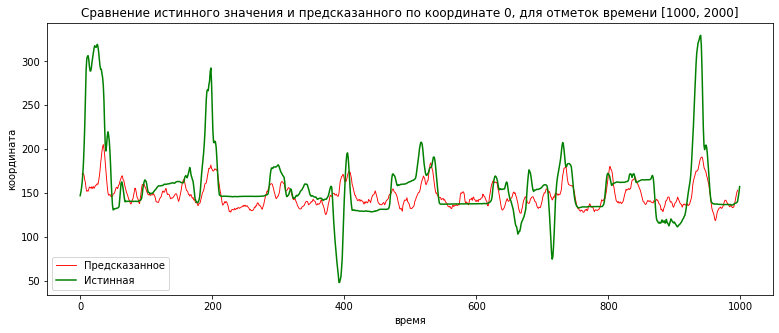

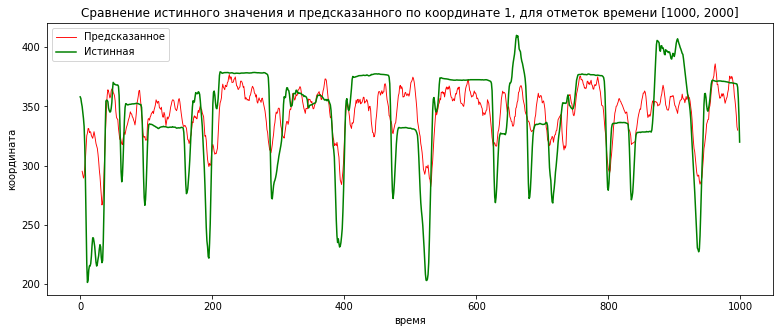

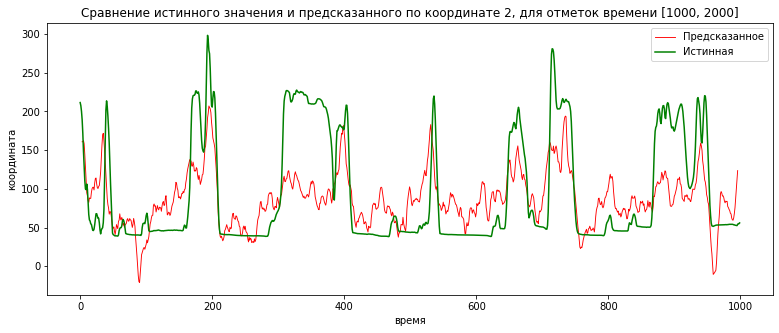

In [489]:
for coord in range(3):
    plt.figure(figsize=(13,5))
    plt.title("Сравнение истинного значения и предсказанного по координате %d, для отметок времени [%d, %d]" % (coord, ft[0], ft[1]))
    plt.plot(np.arange(k//2,(ft[1]-ft[0]) - k//2), smooth(Y_pred[ft[0]:ft[1],coord], k), c='r', lw=0.9, label="Предсказанное")
    plt.plot(np.arange(ft[1]-ft[0]), y_train[ft[0]:ft[1],coord], c='g', label="Истинная")
    plt.xlabel("время")
    plt.ylabel("координата")
    plt.legend()
    plt.show()

Посмотрим на предсказание в 3х мерном пространстве.

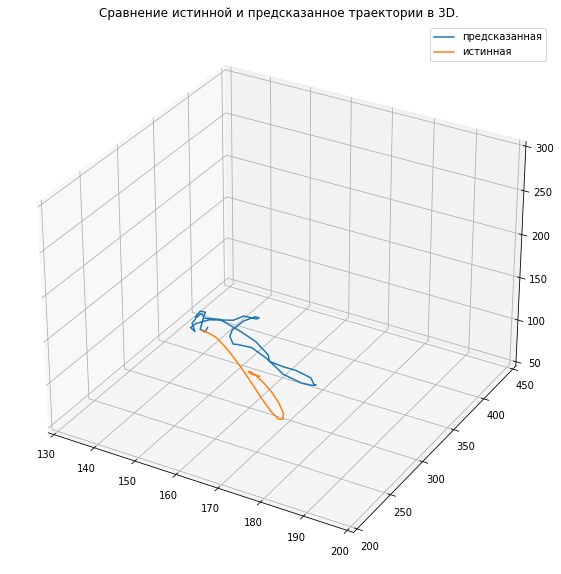

In [479]:
filenames = []
start = 1900 # начало времени
step = 2 # шаг смены кадра
window=50 # сколько последних временных точек хранить на экране

for i in range(start,start+130,step):
    start_window = start if start+window>=i else i - window
    fig = plt.figure(figsize=(10,10))
    
    ax = plt.axes(projection='3d')
    ax.set_title("Сравнение истинной и предсказанное траектории в 3D.")
    ax.set_xlim([130,200])
    ax.set_ylim([200,450])
    ax.set_zlim([50,300])
    ax.plot3D(smooth(Y_pred[start_window:i,0],5), smooth(Y_pred[start_window:i,1], 5), smooth(Y_pred[start_window:i,2], 5),label="предсказанная")
    ax.plot3D(smooth(y_train[start_window:i,0],5), smooth(y_train[start_window:i,1], 5), smooth(y_train[start_window:i,2], 5), label="истинная")
    plt.legend()

    #time.sleep(0.1)
    
    
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.show()
    
    plt.close()
    clear_output(wait=True)

In [480]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

Посмотрим как спарвится обычная линейная регрессия.

In [224]:
lin_mod = PLSRegression().fit(X_train[:,:, 1:].reshape((12801, -1)),y_train)

In [225]:
Y_pred_lin = lin_mod.predict(X_train[:,:, 1:].reshape((12801, -1)))

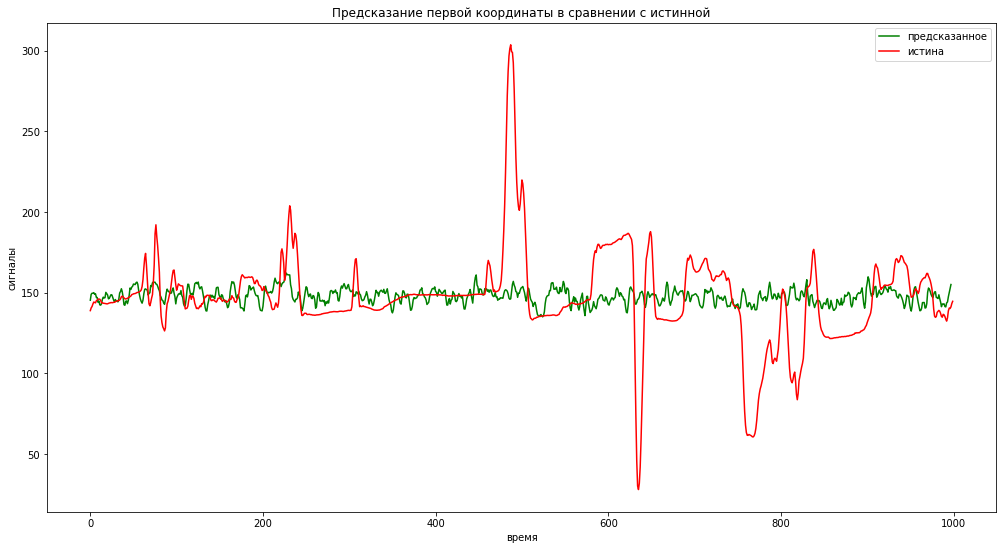

In [482]:
plt.figure(figsize=(17,9))
plt.title("Предсказание первой координаты в сравнении с истинной")
plt.plot(np.arange(998), smooth(Y_pred_lin[:1000,0], 3), c='g', label="предсказанное")
plt.plot(np.arange(1000), y_train[:1000,0], c='r', label="истина")
plt.xlabel("время")
plt.ylabel("сигналы")
plt.legend()
plt.show()

Обычная линейная регрессия справилась плохо, а вот PLS угадывал почти все пики и предсказал хорошую траекторию. Хотя это всего лишь линейный метод.